# Motor Imagery in ECoG Recordings, session-to-session transfer

In [1]:

import mne
from mne.io import RawArray
from mne.preprocessing import ICA
from mne.time_frequency import tfr_multitaper


import numpy as np
from numpy import genfromtxt

import pylab as pl
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA


TEST_PATH = '/Users/lin/Desktop/BCICompetitionIII/DatasetI/Competition_test.mat'
TRAIN_PATH = '/Users/lin/Desktop/BCICompetitionIII/DatasetI/Competition_train.mat'
SAMPLE_FREQ = 1000


## Import the data

> * The time series of the electrical brain activity was picked up during these trials using a 8x8 ECoG platinum electrode grid which was placed on the contralateral (right) motor cortex.
> * All recordings were performed with a sampling rate of 1000Hz. 
> * After amplification the recorded potentials were stored as microvolt values.
> * Every trial consisted of either an imagined tongue or an imagined finger movement and was recorded for 3 seconds duration.
> * Format: [trials, electrode channels, samples of time series]
> * After amplification the recorded potentials were stored as microvolt values

In [2]:
mat_test = loadmat(TEST_PATH)
print("Variable mat_test contains:")
print(mat_test.keys())

test = np.array(mat_test['X'])
print("\nDimension of testing dataset:")
print(test.shape)

print("\n\n")

mat_train = loadmat(TRAIN_PATH)
print("Variable mat_train contains:")
print(mat_train.keys())

train = np.array(mat_train['X'])
label = np.array(mat_train['Y'])
print("\nDimension of training dataset:")
print(train.shape)
print("\nDimension of label set:")
print(label.shape)



trail_num = train.shape[0]
chan_num = train.shape[1]
sample_num = train.shape[2]
print("\n\n")
print("Training set has " + str(chan_num) + " channels.")
print("Training set has " + str(trail_num) + " trails.")
print("Each recording has " + str(sample_num) + " samples")


Variable mat_test contains:
dict_keys(['__header__', '__version__', '__globals__', 'X'])

Dimension of testing dataset:
(100, 64, 3000)



Variable mat_train contains:
dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y'])

Dimension of training dataset:
(278, 64, 3000)

Dimension of label set:
(278, 1)



Training set has 64 channels.
Training set has 278 trails.
Each recording has 3000 samples


In [3]:
%%capture
raw = [None] * trail_num

info = mne.create_info(ch_names = chan_num,
                       sfreq = SAMPLE_FREQ,
                       ch_types = 'ecog')

for x in range(trail_num):
    raw[x] = RawArray(train[x], info)

### Display a sample of ECoG and its power spectral density

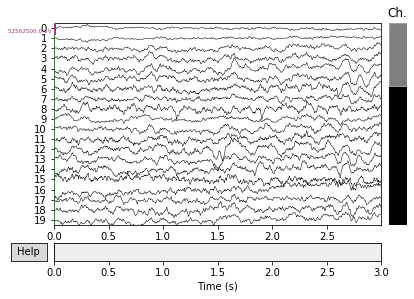

Effective window size : 2.048 (s)


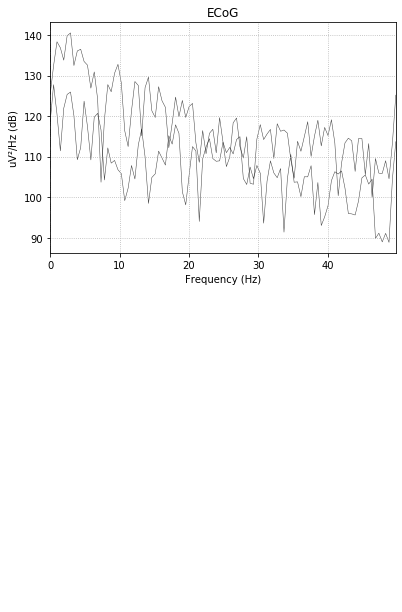

In [4]:
raw[0].plot(scalings = 'auto');
raw[0].plot_psd(fmax = 50, picks = [0,12], spatial_colors = False);

## Architecture of the algorithm
<img src = "img/archi.png" width=600>


## Preprocessing
* ICA features 
<br> <img src = 'img/ICA.png' width = 1000> <br>
* AAR features
* CSP features
* Time-freq features


### ICA  
ICA finds the independent sources that compose the original singal.
<br>
* Not sure if I should create one ICA for all signals or one ICA for each trail.
* current approach is to train one for all, have not finished yet
* an issue here: ICA not converge

In [5]:
ica = ICA(n_components = 20, random_state = 97)
ica_comp = [None] * trail_num

ica.fit(raw[x])

for x in range(trail_num):
    ica_comp[x] = ica.get_sources(raw[x])

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 20 components
Fitting ICA took 0.1s.


### Display two samples of ICA from trails 1 and 2

First 20 ICA components of the first trail:
<RawArray  |  None, n_channels x n_times : 20 x 3000 (3.0 sec), ~511 kB, data loaded>


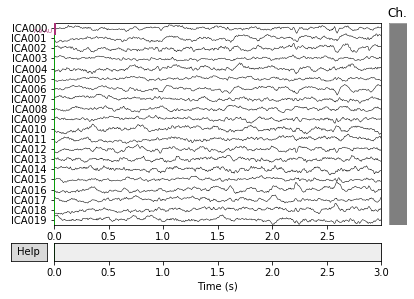



First 20 ICA components of the second trail:
<RawArray  |  None, n_channels x n_times : 20 x 3000 (3.0 sec), ~511 kB, data loaded>


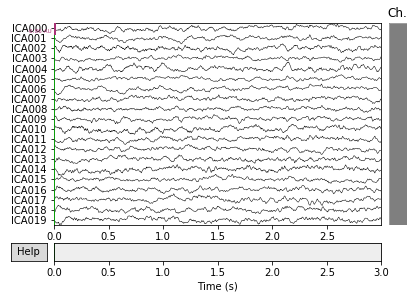

In [6]:
print("First 20 ICA components of the first trail:")
print(ica_comp[0])
ica_comp[0].plot(scalings = 'auto');
print("\n\nFirst 20 ICA components of the second trail:")
print(ica_comp[1])
ica_comp[1].plot(scalings = 'auto');

### Time-frequency
Transform the signals to time-frequency domain by the Multitaper transform method<br>
Steps:
1. Create events 

In [7]:
epoch_time = .3 #int(sample_num / 10) / SAMPLE_FREQ
tmin = 0
tmax = epoch_time - 0.01

events = mne.make_fixed_length_events(raw[0], duration = epoch_time)
print(events)

[[   0    0    1]
 [ 300    0    1]
 [ 600    0    1]
 [ 900    0    1]
 [1200    0    1]
 [1500    0    1]
 [1800    0    1]
 [2100    0    1]
 [2400    0    1]
 [2700    0    1]]


2. Divide the signals into epochs and display a sample of epoch

In [8]:
%%capture

epochs = [None] * trail_num

for x in range(trail_num):
    epochs[x] = mne.Epochs(raw[x], events = events,
                           tmin = tmin, tmax = tmax,
                           baseline = None)

<Epochs  |   10 events (good & bad), 0 - 0.29 sec, baseline off, ~125 kB, data not loaded,
 '1': 10>
Loading data for 10 events and 291 original time points ...
0 bad epochs dropped
Loading data for 10 events and 291 original time points ...
Loading data for 10 events and 291 original time points ...


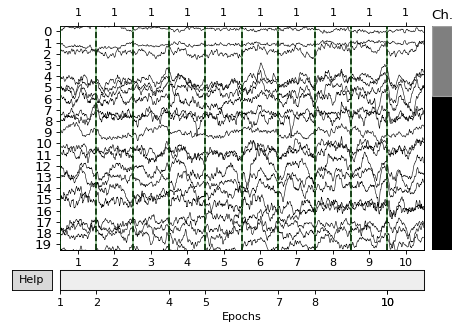

In [9]:
print(epochs[0])
epochs[0].plot(scalings = 'auto');

3. Multitaper transformation and display time-frequency representation

In [10]:
#vmin, vmax = -3., 3.  # Define our color limits.
tfr_freqs = np.arange(4., 50., 2.)
n_cycles = SAMPLE_FREQ / 2
power = [None] * trail_num


for x in range(trail_num):
    print(x)
    power[x] = tfr_multitaper(epochs[x], return_itc = False, 
                           freqs = tfr_freqs, n_cycles = n_cycles)

0
Loading data for 10 events and 291 original time points ...


ValueError: At least one of the wavelets is longer than the signal. Use a longer signal or shorter wavelets.

The error occured because the time-window has to be smaller than the legnth of its epoch. time-window = n_cycles / freq. <br>
However when n_cycles is freq divided by 2, the time-window is 0.5, which is larger than 0.3. A smaller is n_cycles is required. 

### Solution for the issue

In [49]:
tfr_freqs = np.arange(2., 15., 1)
n_cycles = tfr_freqs / 10

print("The time-windows for each frequencies are")
print(n_cycles / tfr_freqs)
print(", which are all less than " + str(epoch_time))

The time-windows for each frequencies are
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
, which are all less than 0.3


In [50]:
%%capture

power = [None] * trail_num
for x in range(trail_num):
    print("Now transforming trail " + str(x))
    power[x] = tfr_multitaper(epochs[x], return_itc = False, 
                           freqs = tfr_freqs, n_cycles = n_cycles)

Applying baseline correction (mode: mean)


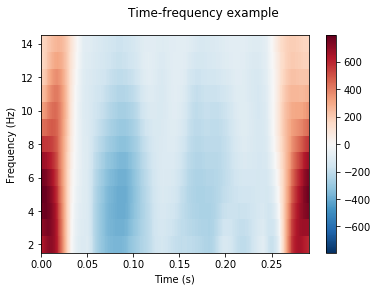

In [51]:
power[0].plot([0], baseline = (0., 0.1), mode = 'mean',
              title = 'Time-frequency example');

### AAR

### CSP

## Feature Selection
Try the features extracted above, and find a set of feature that gives the highest accuracy for Support Vector Machine. This step is only for supervised learning. The feature selection precess would not be involved in the semi-supervised session
* Raw data fed into SVM
* ICA feature fed into SVM
* Time-frequency fed into SVM

Note: features are calculated from predetermined algorithms, such as ICA or Fourier Decomp, so there is no adaptation process. After selecting the best feature for SVM, the feature then can be dynamically adapted for each trail. 



### Spilt the dataset into testing and training set

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(train, label, 
                                                    test_size=0.1,
                                                    random_state = 7)
# convert labels to a vector
Y_train = Y_train[:, 0]
Y_test = Y_test[:, 0]

n_train_trails = X_train.shape[0]
n_test_trails = X_test.shape[0]

print("Dimension of X_train:", X_train.shape)
print("Dimension of Y_train:", Y_train.shape)
print("\nDimension of X_test:", X_test.shape)
print("Dimension of Y_test:", Y_test.shape)

Dimension of X_train: (250, 64, 3000)
Dimension of Y_train: (250,)

Dimension of X_test: (28, 64, 3000)
Dimension of Y_test: (28,)


### Train SVMs on raw data
Each SVM is trained different time segment.

Divide the 3 seconds signal into 6 segments.
Dimension for each sample: 500.0


Now training SVM on time segment from 0 to 500
Accuracy: 0.6428571428571429
Now training SVM on time segment from 500 to 1000
Accuracy: 0.7142857142857143
Now training SVM on time segment from 1000 to 1500
Accuracy: 0.8214285714285714
Now training SVM on time segment from 1500 to 2000
Accuracy: 0.7857142857142857
Now training SVM on time segment from 2000 to 2500
Accuracy: 0.6428571428571429
Now training SVM on time segment from 2500 to 3000
Accuracy: 0.75


Text(0.5, 1.0, 'Accuracy of SVM at certain time period')

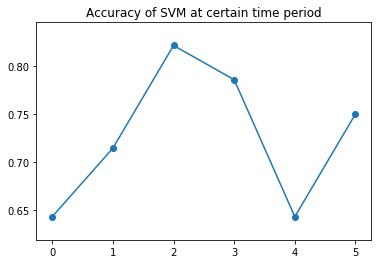

In [48]:
time_segments = 6
n_features = sample_num/time_segments

print("Divide the 3 seconds signal into " + str(time_segments) + " segments.")
print("Dimension for each sample: " + str(n_features))
print("\n")

fig, arr = plt.subplots()

# initialization of x-y axis of time-accuracy graph
accuracy = np.zeros(time_segments)
xaxis = np.zeros(time_segments)

# separate test/training dataset(optional)
#X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.1)

for x in range(time_segments):
    # select the hyperparameter: time period, for each iteration
    i = int(x * n_features)
    f = int((x + 1) * n_features)
    print("Now training SVM on time segment from " + str(i) + " to " + str(f))
    
    segment_train = X_train[:, :, i : f].reshape((n_train_trails, int(chan_num * n_features)))
    segment_test = X_test[:, :, i : f].reshape((n_test_trails, int(chan_num * n_features)))
    
    # calculate SVM with different hyperparameters
    clf_AAR = svm.SVC(kernel = 'linear', C = 100).fit(segment_train, Y_train)
    
    # store the accuracy and print on the terminal
    accuracy[x] = clf_AAR.score(segment_test, Y_test)
    xaxis[x] = x
    
    print("Accuracy: " + str(accuracy[x]))

# rendering Accuracy of SVM at certain time period
arr.scatter(xaxis, accuracy)
arr.plot(xaxis, accuracy)
arr.set_title('Accuracy of SVM at certain time period')

## Domain Adaptation

## Semi-supervised (fake) online adaptation